# Predicting `Sales` from `Carseats` dataset using decision trees and related approaches

#### In this analysis, we will be predicting Sales from other predictors in the Carseats dataset using regressive decision trees, bagging, random forests, Bayesian Additive Regression Trees, and boosting.

In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.datasets import get_rdataset
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS
from sklearn.tree import (DecisionTreeClassifier as DTC, DecisionTreeRegressor as DTR, plot_tree, export_text)
from sklearn.metrics import (accuracy_score, log_loss)
from sklearn.ensemble import (RandomForestRegressor as RF, GradientBoostingRegressor as GBR)
from ISLP.bart import BART

## Splitting data into training and test set

In [2]:
Carseats = load_data('Carseats')
Carseats

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...
395,12.57,138,108,17,203,128,Good,33,14,Yes,Yes
396,6.14,139,23,3,37,120,Medium,55,11,No,Yes
397,7.41,162,26,12,368,159,Medium,40,18,Yes,Yes
398,5.94,100,79,7,284,95,Bad,50,12,Yes,Yes


In [4]:
model = MS(Carseats.columns.drop('Sales'), intercept=False)
D = model.fit_transform(Carseats)
feature_names = list(D.columns)
X = np.asarray(D)

In [5]:
(X_train, X_test, y_train, y_test) = skm.train_test_split(X, Carseats['Sales'], test_size=0.3, random_state=0)

## Fitting regression tree to training set

[Text(0.5, 0.875, 'ShelveLoc[Good] <= 0.5\nsquared_error = 8.438\nsamples = 280\nvalue = 7.378'),
 Text(0.25, 0.625, 'ShelveLoc[Medium] <= 0.5\nsquared_error = 6.26\nsamples = 226\nvalue = 6.705'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'Price <= 102.5\nsquared_error = 5.251\nsamples = 71\nvalue = 5.159'),
 Text(0.0625, 0.125, 'squared_error = 4.795\nsamples = 21\nvalue = 6.697'),
 Text(0.1875, 0.125, 'squared_error = 4.031\nsamples = 50\nvalue = 4.512'),
 Text(0.375, 0.375, 'Price <= 106.5\nsquared_error = 5.127\nsamples = 155\nvalue = 7.413'),
 Text(0.3125, 0.125, 'squared_error = 4.149\nsamples = 55\nvalue = 8.743'),
 Text(0.4375, 0.125, 'squared_error = 4.156\nsamples = 100\nvalue = 6.681'),
 Text(0.75, 0.625, 'Price <= 107.5\nsquared_error = 7.698\nsamples = 54\nvalue = 10.198'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'Age <= 55.5\nsquared_error = 3.888\nsamples = 20\nvalue = 12.344'),
 Text(0.5625, 0.125, 'squared_error = 2.928\nsamples = 11\nvalue = 13.395

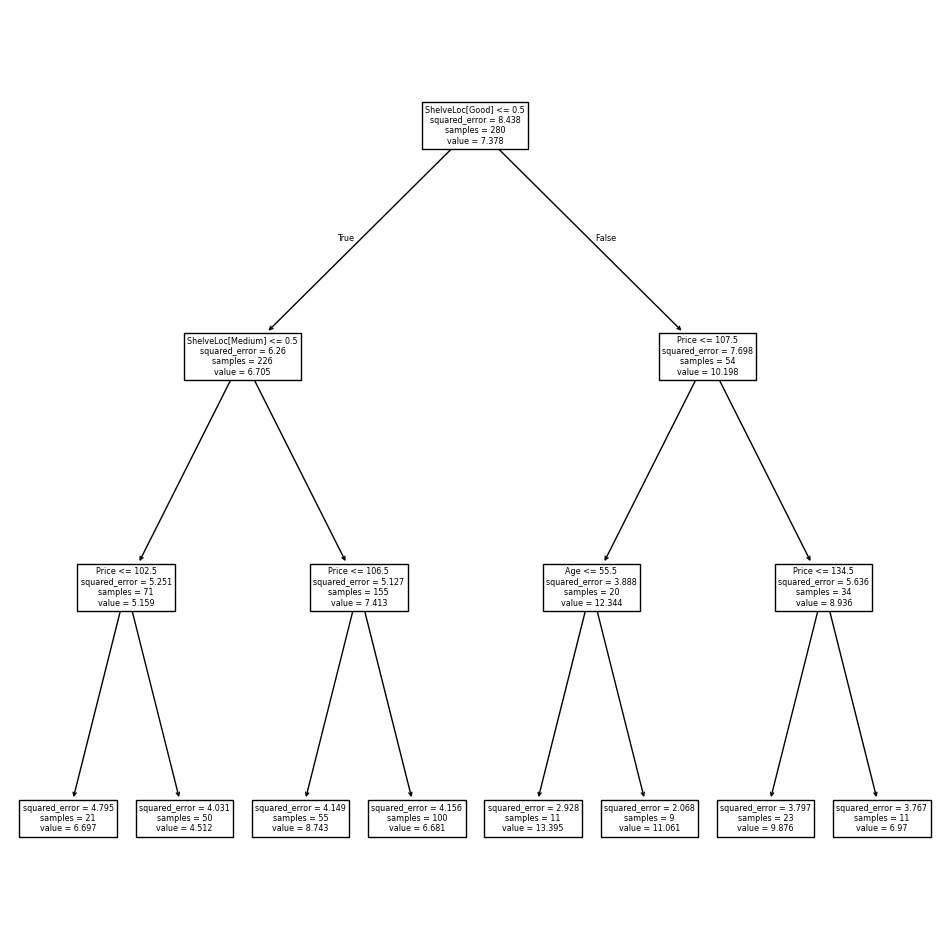

In [7]:
Carseat_reg = DTR(max_depth=3)
Carseat_reg.fit(X_train, y_train)
ax = subplots(figsize=(12, 12))[1]
plot_tree(Carseat_reg, feature_names = feature_names, ax=ax)

Finding test MSE estimate

In [8]:
y_hat = Carseat_reg.predict(X_test)
np.mean((y_test - y_hat)**2)

3.7038582752360942

MSE is 3.7

## Using Cross-validation to prune the tree for optimal complexity

In [10]:
ccp_path = Carseat_reg.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5, shuffle=True, random_state=0)
grid = skm.GridSearchCV(Carseat_reg, {'ccp_alpha': ccp_path.ccp_alphas}, refit=True, cv=kfold, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=DecisionTreeRegressor(max_depth=3),
             param_grid={'ccp_alpha': array([0.        , 0.09625833, 0.22444027, 0.25210042, 0.52253297,
       0.53848613, 0.88359258, 1.90014702])},
             scoring='neg_mean_squared_error')

In [11]:
best_ = grid.best_estimator_

In [13]:
np.mean((y_test - best_.predict(X_test))**2)

3.6714536191308507

Slightly better MSE, by like 0.03

[Text(0.5416666666666666, 0.875, 'ShelveLoc[Good] <= 0.5\nsquared_error = 8.438\nsamples = 280\nvalue = 7.378'),
 Text(0.3333333333333333, 0.625, 'ShelveLoc[Medium] <= 0.5\nsquared_error = 6.26\nsamples = 226\nvalue = 6.705'),
 Text(0.4375, 0.75, 'True  '),
 Text(0.16666666666666666, 0.375, 'Price <= 102.5\nsquared_error = 5.251\nsamples = 71\nvalue = 5.159'),
 Text(0.08333333333333333, 0.125, 'squared_error = 4.795\nsamples = 21\nvalue = 6.697'),
 Text(0.25, 0.125, 'squared_error = 4.031\nsamples = 50\nvalue = 4.512'),
 Text(0.5, 0.375, 'Price <= 106.5\nsquared_error = 5.127\nsamples = 155\nvalue = 7.413'),
 Text(0.4166666666666667, 0.125, 'squared_error = 4.149\nsamples = 55\nvalue = 8.743'),
 Text(0.5833333333333334, 0.125, 'squared_error = 4.156\nsamples = 100\nvalue = 6.681'),
 Text(0.75, 0.625, 'Price <= 107.5\nsquared_error = 7.698\nsamples = 54\nvalue = 10.198'),
 Text(0.6458333333333333, 0.75, '  False'),
 Text(0.6666666666666666, 0.375, 'squared_error = 3.888\nsamples = 20\nv

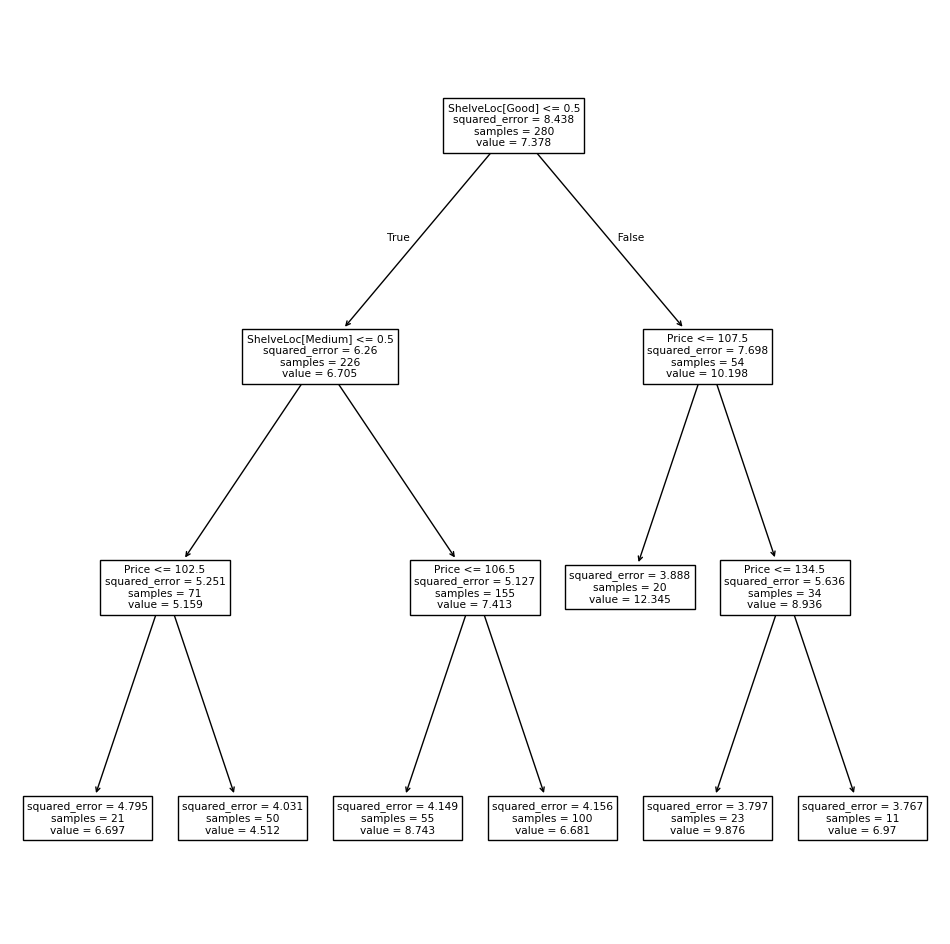

In [14]:
ax = subplots(figsize=(12, 12))[1]
plot_tree(best_, feature_names=feature_names, ax=ax)

Has less terminal nodes too, so CV leads to a simpler model that has a lower test MSE

## Using bagging to analyze data

Bagging is just Random Forest models with $m=p$

In [16]:
carseat_bag = RF(max_features=X_train.shape[1], random_state=0)
carseat_bag.fit(X_train, y_train)

RandomForestRegressor(max_features=11, random_state=0)

2.0077445197500015

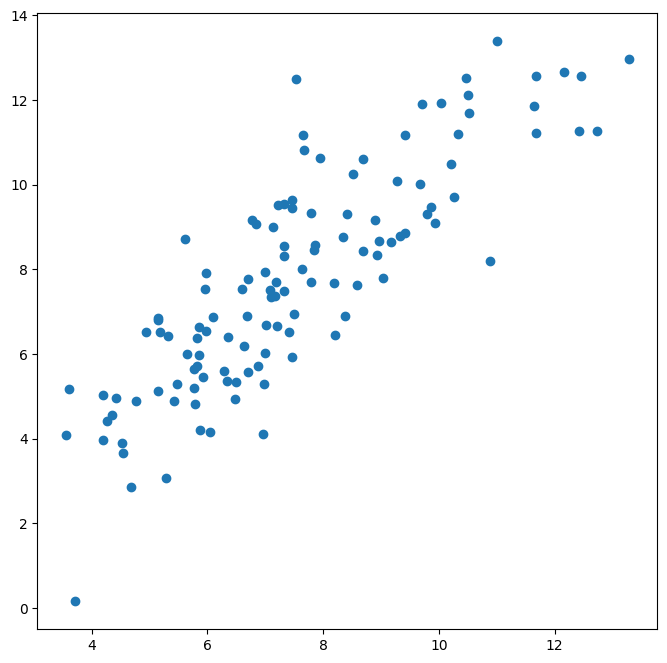

In [17]:
ax = subplots(figsize=(8,8))[1]
y_hat_bag = carseat_bag.predict(X_test)
ax.scatter(y_hat_bag, y_test)
np.mean((y_test - y_hat_bag)**2)

Test MSE of 2.01, so better than the regression trees fitted before

Changing number of trees to 500

In [19]:
carseat_bag = RF(max_features=X_train.shape[1], n_estimators=500, random_state=0).fit(X_train, y_train)
y_hat_bag = carseat_bag.predict(X_test)
np.mean((y_test - y_hat_bag)**2)

2.0236328641333428

MSE actually went up, so sticking with default of 100 trees

In [20]:
feature_imp = pd.DataFrame({'importance': carseat_bag.feature_importances_}, index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
Price,0.286600
ShelveLoc[Good],0.220007
Age,0.105353
CompPrice,0.100679
ShelveLoc[Medium],0.085092
Advertising,0.068876
Income,0.053628
Population,0.039242
Education,0.029639
US[Yes],0.006542


Price and a ShelveLoc of Good (encoded categorical variable) have the highest importance in predicting Sales 

## Using random forests to analyze the data

In [38]:
MSE = []
for m in range(1, X_train.shape[0]):
    carseat_RF = RF(max_features=m, random_state=0).fit(X_train, y_train)
    y_hat_RF = carseat_RF.predict(X_test)
    MSE.append(np.mean((y_test - y_hat_RF)**2))
print(f"Lowest MSE was {min(MSE)} using {np.argmin(MSE) + 1} predictors")

Lowest MSE was 1.9720165405000003 using 7 predictors


The MSE went down until 7 predictors, the minimum, and then it increased after

In [39]:
feature_imp_RF = pd.DataFrame({'importance': carseat_RF.feature_importances_}, index=feature_names)
feature_imp_RF.sort_values(by='importance', ascending=False)

,importance
Price,0.278666
ShelveLoc[Good],0.222431
Age,0.108637
CompPrice,0.097085
ShelveLoc[Medium],0.082965
Advertising,0.074627
Income,0.051799
Population,0.040945
Education,0.030836
US[Yes],0.006815


Same predictors as the bagging model were the most important to predicting Sales

## Analyzing data using Bayesian Additive Regression Trees

In [40]:
carseat_bart = BART(random_state=0, burnin=5, ndraw=15)
carseat_bart.fit(X_train, y_train)

BART(burnin=5, ndraw=15, random_state=0)

In [41]:
y_hat_bart = carseat_bart.predict(X_test)
np.mean((y_test - y_hat_bart)**2)

1.7171824254893664

Much lower MSE than random forest considering 7 predictors, which was the lowest MSE so far

Viewing how many times each variable appeared in the collection of trees

In [43]:
var_inclusion = pd.Series(carseat_bart.variable_inclusion_.mean(0), index=D.columns)
var_inclusion

CompPrice            29.600000
Income               21.266667
Advertising          27.200000
Population           25.866667
Price                34.266667
ShelveLoc[Good]      33.266667
ShelveLoc[Medium]    27.266667
Age                  33.733333
Education            24.200000
Urban[Yes]           25.800000
US[Yes]              26.400000
dtype: float64

## Analyzing the data using Boosting

In [44]:
carseat_boost = GBR(n_estimators=5000, learning_rate=0.001, max_depth=3, random_state=0)
carseat_boost.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.001, n_estimators=5000,
                          random_state=0)

In [45]:
np.mean((y_test - carseat_boost.predict(X_test)))

0.2753675188339529

Varying learning rate (0.001 to 0.1) and looking at in-sample and out-of-sample MSE

In [48]:
train_MSE = []
test_MSE = []
learning_rates = np.arange(0.001, 0.1, 0.001) 

for lr in learning_rates:
    carseat_boost = GBR(n_estimators=5000, learning_rate=lr, max_depth=3, random_state=0)
    carseat_boost.fit(X_train, y_train)
    train_MSE.append(np.mean((y_train - carseat_boost.predict(X_train))**2))
    test_MSE.append(np.mean((y_test - carseat_boost.predict(X_test))**2))

min_trmse_idx = np.argmin(train_MSE)
min_trmse = train_MSE[min_trmse_idx]
best_trlr = learning_rates[min_trmse_idx]

min_temse_idx = np.argmin(test_MSE)
min_temse = test_MSE[min_temse_idx]
best_telr = learning_rates[min_temse_idx]

print(f"Lowest training MSE was {min_trmse} using learning rate {best_trlr}")
print(f"Lowest test MSE was {min_temse} using learning rate {best_telr}")

Lowest training MSE was 1.1158313523709394e-15 using learning rate 0.098
Lowest test MSE was 2.064701015896659 using learning rate 0.001


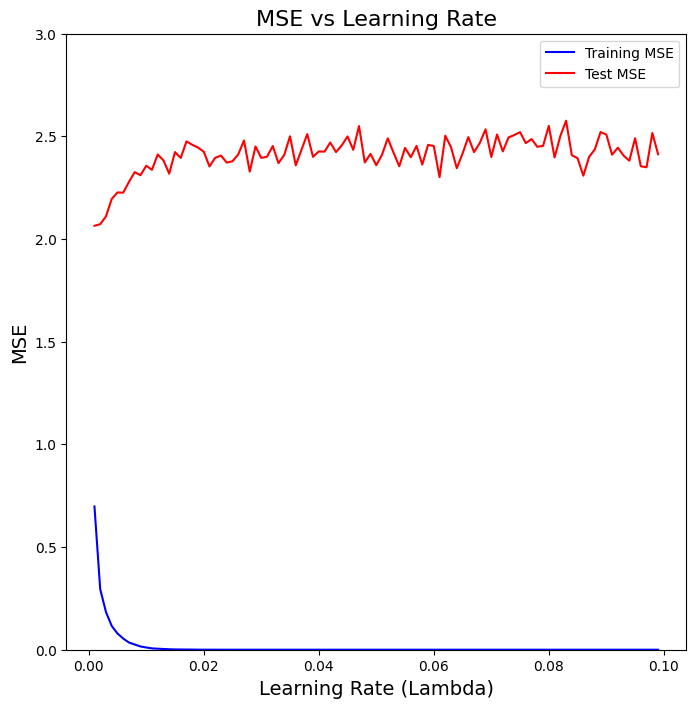

In [54]:
ax = subplots(figsize=(8,8))[1]
ax.plot(learning_rates, train_MSE, color='blue', label='Training MSE')
ax.plot(learning_rates, test_MSE, color='red', label='Test MSE')
ax.set_ylim([0, 3])
ax.set_xlabel('Learning Rate (Lambda)', fontsize=14)
ax.set_ylabel('MSE', fontsize=14)
ax.set_title('MSE vs Learning Rate', fontsize=16)
ax.legend()


Test MSE is higher than some of the other models, greater learning rate might change it since we only considered 0.001 to 0.1

In [59]:
carseat_boost_big = GBR(n_estimators=5000, learning_rate=0.15, max_depth=3, random_state=0)
carseat_boost_big.fit(X_train, y_train)
np.mean((y_test - carseat_boost_big.predict(X_test))**2)

2.556302473684167

Manual increases of the learning rate only lead to increases in MSE, so 0.001 is most likely where the minimum test MSE occurs

Overall, when considering all the models used in this analysis predicting `Sales` from other predictors in the `Carseat` dataset, the **Bayesian Additive Regression Tree (BART) Model had the lowest test MSE, with an MSE of 1.72**. However, more hyperparameter tuning could lead to lower errors.